# Producing multiple peaked synthetic profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining, whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  
 
To construct multiple peaked events, we need to consider:  
 1) The rainfall volume$ V_1,...V_N$ for each peak. Suggestion: use $V/N$, so we have the same total rainfall.  
 2) The shape of each peak. Suggestion: use the same shape, but different peak rainfall height so it gives the desired volume  given a start-to-end duration for the peak.  
 3) The start-to-end duration of each peak. This is a parameter we can play with, but probably we will mainly look at short durations.  
 4) The spacing between peaks. Here, the question is what a "fair" spacing for comparison so that the overall "event duration" is the same, and this is probably a bit subjective. We could also consider this as another parameter to play with.  
 


In [19]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [2]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
durations = ['1h', '3h', '6h']

### Create dataframe for one method containing the accumulation and rate at each minute of time

In [10]:
# For each method produce a dataframe containing precipitation values for each minute and save these to file
for duration in ['6h']:
    for method in methods:
        print(method, duration)
        
        ## PARAMETER SETTINGS
        N_subpeaks= 3
        total_duration_minutes= int(duration[0]) * 60
        subpeak_duration_minutes=total_duration_minutes/6
        if duration == '1h':
            total_mm_accum= 38.7
        elif duration == '3h':
            total_mm_accum= 51.3
        elif duration == '6h':
              total_mm_accum= 59.98
        default_peak_shape='refh2-summer'
        
        # Create datetimes to go with values
        start = datetime(2022,8,1,0,0,0)
        end = start + relativedelta(hours=int(duration[0]))
        end = end - timedelta(minutes=1) 
        seconds = (end - start).total_seconds() + 60
        step = timedelta(minutes=1)
        datetimes = []
        for i in range(0, int(seconds), int(step.total_seconds())):
            datetimes.append(start + timedelta(seconds=i))       
        
        # Find accumulation and rate
        accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
        # Create as dataframe
        accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
        # Keep only columns needed for feeding to ReFH2
        accum_df = accum_df[['Dates','Rate (mm/min)']]
        
        # Write to csv
        accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_{}.csv".format(duration,duration, method),
                       header = False, index = False)

single-peak 6h
divide-time 6h
max-spread 6h
subpeak-timing 6h


# Plot post loss removal profiles

In [44]:
os.getcwd()

'/nfs/a319/gy17m2a/PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/SyntheticProfiles'

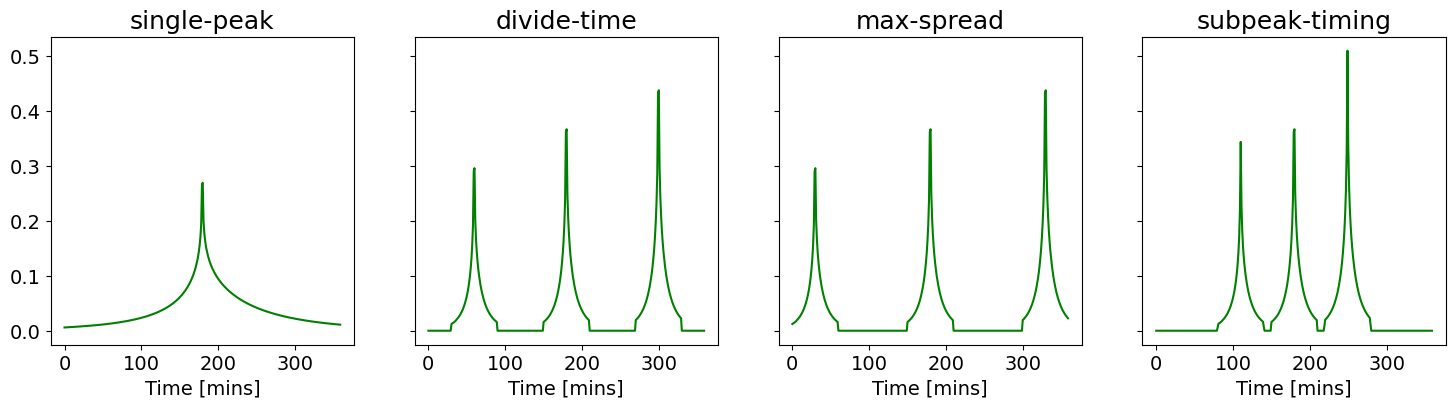

In [46]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
durations = ['1h', '3h', '6h']

# # Set size of x/y tick labels in all subplots
# plt.rcParams['xtick.labelsize'] = 14
# plt.rcParams['ytick.labelsize'] = 14

# Create figure
fig, axes = plt.subplots(1, len(methods), figsize=(18,4), sharex =True, sharey = True)

# Read in data
for axes_number, method in enumerate(methods):
    post_loss_removal = pd.read_csv("../SyntheticProfiles/" + "6hr_100yrRP/PostLossRemoval/6h_{}_urban.csv".format(method))
    # Filter to only include those within the first 6 hours
    post_loss_removal = post_loss_removal[:360]
    # Convert date to datetime
    post_loss_removal['Time'] =  np.array(range(total_duration_minutes))    
    # PLot
    axes[axes_number].plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = 'green')
    axes[axes_number].set_title(method, fontsize = 18)
    axes[axes_number].set_xlabel('Time [mins]', fontsize = 14)
fig.savefig('6hr_100yrRP/PostLossRemoval/multipeaked_scenarios.png', bbox_inches="tight");    